In [10]:
import mpfit3 as mpfit #https://code.google.com/archive/p/astrolibpy/downloads
import pandas as pd
import numpy as np
from astropy.io import fits
import orbital #install orbitalpy
import pickle
import matplotlib.pyplot as plt

earth=pd.read_csv('earth.csv',dtype='d')
year=365.25
d=fits.open('S1_detection_table.fits')
dd=d[1].data
d.close()

def makeorbit(t,p,dec,isprimary):
    a=np.where(isprimary==2)[0]
    b=np.where(isprimary==3)[0]
    per=t/p[6]*2*np.pi+p[7]
    
    th=np.zeros(len(t)+len(b),dtype='d')
    rad=np.zeros(len(t)+len(b),dtype='d')
    for i in range(len(rad)):
        while per[i]>2*np.pi: per[i]=per[i]-2*np.pi
        try:
            th[i]=orbital.utilities.true_anomaly_from_mean(p[5],per[i])
            rad[i]=orbital.utilities.orbit_radius(1.,p[5],th[i])
        except:
            pass
    
    
    if len(a)>0: th[a]=th[a]+np.pi
    if len(b)>0:
        c=b+len(b)
        th[c]=th[b]+np.pi
        r[c]=r[b]
    
    x1=rad*p[9]*(np.cos(th+p[8])*np.sin(p[12])-np.sin(th+p[8])*np.cos(p[12])*np.cos(p[11]))/np.cos(np.radians(dec))
    y1=rad*p[9]*(np.sin(th+p[8])*np.sin(p[12])*np.cos(p[11])+np.cos(th+p[8])*np.cos(p[12]))
    
    if len(a)>0:
        x1[a]=x1[a]/p[10]
        y1[a]=y1[a]/p[10]
    if len(b)>0:
        x1[c]=x1[c]-x1[c]/p[10]
        y1[c]=x1[c]-y1[c]/p[10]
        x1=x1[range(len(t))]
        y1=y1[range(len(t))]
        
    return(x1,y1)

def fitfunc(p, y=None, err=None, fa=None,fb=None,t=None,isprimary=None,fjac=None):
    #p[0] - parallax
    #p[1:2] - proper motion of the system
    #p[3:4] - center of the system
    #p[5] - eccentricity
    #p[6] - period
    #p[7] - mean anomaly of the first observation
    #p[8] - longitude of periastron
    #p[9] - semimajor axes
    #p[10] - mass ratio
    #p[11] - inclination
    #p[12] - Longitude of the ascending node
    #p[13:14] - acceleration
    
    coord1 = t*np.cos(np.radians(y[:,1]))*p[1]+fa*p[0]+p[3]+(t**2)*np.cos(np.radians(y[:,1]))*p[13]/2.
    coord2 = t*p[2]+fb*p[0]+p[4]+(t**2)*p[14]/2.
    
    x1,y1=makeorbit(t,p,y[:,1],isprimary)
    r1=(y[:,0] - coord1-x1)/err[:,0]
    d1=(y[:,1] - coord2-y1)/err[:,1]
    
    status=0
    return([status,np.append(r1,d1)])

def makemodel(p,start,flag):
    t=(earth['date'].values-start)
    dec=p[4]+p[2]*t+p[14]*(t**2)/2.
    ra=p[3]+(p[1]*np.cos(np.radians(dec)))*t+(p[13]*np.cos(np.radians(dec)))*(t**2)/2
    x1,y1=makeorbit(t,p,dec,np.zeros(len(ra))+flag)
    fa=((earth['ex']*np.sin(np.radians(ra))-earth['ey']*np.cos(np.radians(ra)))/(np.cos(np.radians(dec)))).values
    fb=(earth['ex']*np.cos(np.radians(ra))*np.sin(np.radians(dec))+earth['ey']*np.sin(np.radians(ra))*np.sin(np.radians(dec))-earth['ez']*np.cos(np.radians(dec))).values
    ra=ra+fa*p[0]+x1
    dec=dec+fb*p[0]+y1
    return(ra,dec)

def loaddata(i,j=None,k=None):
    ii=np.where(dd['ra'][i]>0)[0]
    ra_d=dd['ra'][i][ii]
    dec_d=dd['dec'][i][ii]
    re=dd['rae(as)'][i][ii]/3600
    de=dd['dece(as)'][i][ii]/3600
    date=dd['date'][i][ii]
    x=dd['x'][i][ii]
    y=dd['y'][i][ii]
    z=dd['z'][i][ii]
    isprimary=np.zeros(len(ii))+1
    if j !=None:
        jj=np.where(dd['ra'][j]>0)[0]
        ra_d=np.append(ra_d,dd['ra'][j][jj])
        dec_d=np.append(dec_d,dd['dec'][j][jj])
        re=np.append(re,dd['rae(as)'][j][jj]/3600)
        de=np.append(de,dd['dece(as)'][j][jj]/3600)
        date=np.append(date,dd['date'][j][jj])
        x=np.append(x,dd['x'][j][jj])
        y=np.append(y,dd['y'][j][jj])
        z=np.append(z,dd['z'][j][jj])
        isprimary=np.append(isprimary,np.zeros(len(jj))+2)
        
        
    #add a prescription for the relative astrometry data in terms of their ra&dec positional offset e.g.
    ##readcol,'DoAr51.ir',irdate,irrho,irrhoe,irtheta,irthetae,format='d,d,d,d,d'
    #x=-irrho*np.cos(np.radians(irtheta+90))/1e3/3600
    #y=irrho*np.sin(np.radians(irtheta+90))/1e3/3600
    #xe=-irrhoe*np.cos(np.radians(irtheta+90))/1e3/3600+irrho*np.sin(np.radians(irtheta+90))/1e3/3600*(np.radians(irthetae))
    #ye=irrhoe*sin(np.radians(irtheta+90))/1e3/3600+irrho*np.cos(np.radians(irtheta+90))/1e3/3600*(np.radians(irthetae))
    #x and y are added to ra_d and dec_d, xe and ye are added to re and de; add date, xyz do not matter, can be any arbitrary value
    #set isprimary=3 for all relative epochs
        
    fa=(x*np.sin(np.radians(ra_d))-y*np.cos(np.radians(ra_d)))/(np.cos(np.radians(dec_d)))
    fb=x*np.cos(np.radians(ra_d))*np.sin(np.radians(dec_d))+y*np.sin(np.radians(ra_d)
                            )*np.sin(np.radians(dec_d))-z*np.cos(np.radians(dec_d))
    
    
    data={'ra_d':ra_d,'dec_d':dec_d,'re':re,'de':de,'date':date,'x':x,'y':y,'z':z,'fa':fa,'fb':fb,'isprimary':isprimary}
    return(data)

def rungrid(data,acceleration=False,startperiod=1,stopperiod=20,stepperiod=0.3,startecc=0.,stopecc=0.8,stepecc=0.2,savepath=None):
    
    t=data['date']-data['date'][0]
    
    yvals=np.append(np.reshape(data['ra_d'],[len(t),1]),np.reshape(data['dec_d'],[len(t),1]),1)
    errvals=np.append(np.reshape(data['re'],[len(t),1]),np.reshape(data['de'],[len(t),1]),1)
    args = {'fa':data['fa'],'fb':data['fb'],'t':t,'isprimary':data['isprimary'], 'y':yvals, 'err':errvals}
    
    parinfo = [{'value':0., 'fixed':0, 'limited':[0,0], 'limits':[0.,0.]} for i in range(15)]
        
    #parinfo[5]['fixed'] = 1
    parinfo[5]['limited'] = [1,1]
    parinfo[5]['limits']  = [0.0,0.9]
    parinfo[7]['limited'] = [1,1]
    parinfo[7]['limits']  = [0.0,2*np.pi]
    parinfo[8]['limited'] = [1,1]
    parinfo[8]['limits']  = [0.0,2*np.pi]
    parinfo[9]['limited'] = [1,0]
    parinfo[9]['limits']  = [0.0,0.0]
    parinfo[10]['limited'] = [1,1]
    parinfo[10]['limits']  = [0.1,10.0]
    if len(np.where(data['isprimary']>1)[0])==0: parinfo[10]['fixed']=1
    parinfo[11]['limited']=[1,1]
    parinfo[11]['limits']=[0,np.pi]
    parinfo[12]['limited']=[1,1]
    parinfo[12]['limits']=[0,np.pi]
    if not acceleration:
        parinfo[13]['fixed']=1
        parinfo[14]['fixed']=1
        
    i=0
    for p in np.arange(startperiod,stopperiod,stepperiod):i=i+1
    j=0
    for p in np.arange(startecc,stopecc,stepecc):j=j+1
        
    
    num=i*j*12*12
    ksi=np.empty(num)
    params=np.empty([15,num],dtype='d')
    perr=np.empty([15,num])
        
    i=0
    
    
    lp=15
    if not acceleration: lp=lp-2
    if len(np.where(data['isprimary']>1)[0])==0: lp=lp-1
    dof=len(t)*2-lp-1
    for period in np.arange(startperiod,stopperiod,stepperiod,dtype='d'):
        for ecc in np.arange(startecc,stopecc,stepecc,dtype='d'):
            print(period,ecc)
            for start in np.arange(0,360,30):
                for angle in np.arange(0,360,30):
                    mupi=[2.5*1e-3/3600,0.,0.,data['ra_d'][0],data['dec_d'][0],ecc,period*year,
                          np.radians(start),np.radians(angle),0.,1.5,np.pi/2,np.pi/2,0.,0.]
                    m = mpfit.mpfit( fitfunc, mupi, functkw=args,parinfo=parinfo,quiet=1)
                    ksi[i]=m.fnorm/lp
                    params[:,i]=m.params
                    perr[:,i]=m.perror
                    i=i+1
    for i in range(15): perr[i]=perr[i]*np.sqrt(ksi)
    bestfit={'ksi':ksi,'params':params,'perr':perr}
    if savepath != None: pickle.dump(bestfit,open(savepath,"wb" ))
    return(bestfit)

def plotbest(data,bestfit):
    best=np.min(bestfit['ksi'])
    l=np.where(bestfit['ksi']==best)[0]
    fig,ax = plt.subplots(figsize=(10,10))
    
    a=np.where(data['isprimary']==1)[0]
    plt.scatter((data['ra_d'][a]-data['ra_d'][0])*1000*3600,(data['dec_d'][a]-data['dec_d'][0])*1000*3600,c='blue')
    if len(np.where(data['isprimary']>1)[0])!=0:
        b=np.where(data['isprimary']==2)[0]
        plt.scatter((data['ra_d'][b]-data['ra_d'][0])*1000*3600,(data['dec_d'][b]-data['dec_d'][0])*1000*3600,c='red')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().invert_xaxis()
    
    t=np.where((earth['date']>=np.min(data['date'])-100) & (earth['date']<=np.max(data['date'])+100))[0]
    params=bestfit['params'][:,l]
    ra,dec=makemodel(params,np.min(data['date']),1)
    plt.plot((ra[t]-data['ra_d'][0])*1000*3600,(dec[t]-data['dec_d'][0])*1000*3600,c='blue')
    for k in a:
        s=np.where(np.abs(earth['date']-data['date'][k])<=0.5)[0][0]
        plt.scatter((ra[s]-data['ra_d'][0])*1000*3600,(dec[s]-data['dec_d'][0])*1000*3600,edgecolors='blue',marker='d',facecolors='none')
        plt.plot([(ra[s]-data['ra_d'][0])*1000*3600,(data['ra_d'][k]-data['ra_d'][0])*1000*3600],[(dec[s]-data['dec_d'][0])*1000*3600,(data['dec_d'][k]-data['dec_d'][0])*1000*3600],color='blue')
    if len(np.where(data['isprimary']>1)[0])!=0:
        ra1,dec1=makemodel(params,np.min(data['date']),2)
        plt.plot((ra1[t]-data['ra_d'][0])*1000*3600,(dec1[t]-data['dec_d'][0])*1000*3600,c='red')
        for k in b:
            s=np.where(np.abs(earth['date']-data['date'][k])<=0.5)[0][0]
            plt.scatter((ra1[s]-data['ra_d'][0])*1000*3600,(dec1[s]-data['dec_d'][0])*1000*3600,edgecolors='red',marker='d',facecolors='none')
            plt.plot([(ra1[s]-data['ra_d'][0])*1000*3600,(data['ra_d'][k]-data['ra_d'][0])*1000*3600],[(dec1[s]-data['dec_d'][0])*1000*3600,(data['dec_d'][k]-data['dec_d'][0])*1000*3600],color='red')
    plt.show()
    return

def outputsummaryfromfit(bestfit,upto=1.1):
    best=np.min(bestfit['ksi'])
    a=np.where(bestfit['ksi']<best*upto)[0]
    perr=bestfit['perr']
    params=bestfit['params']
    ksi=bestfit['ksi']
    print('paremeters weighted by chi^2 with uncertainties from the fit')
    print('parallax', np.sum(params[0,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)*3600*1e3,np.sum(perr[0,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)*3600*1e3)
    print('pmra', np.sum(params[1,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)*3600*1e3*year,np.sum(perr[1,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)*3600*1e3*year)
    print('pmdec', np.sum(params[2,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)*3600*1e3*year,np.sum(perr[2,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)*3600*1e3*year)
    print('accra', np.sum(params[13,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)*3600*1e3*year**2,np.sum(perr[13,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)*3600*1e3*year**2)
    print('accdec', np.sum(params[14,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)*3600*1e3*year**2,np.sum(perr[14,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)*3600*1e3*year**2)
    print('ra0', np.sum(params[3,a]/ksi[a]**2)/np.sum(1/ksi[a]**2),np.sum(perr[3,a]/ksi[a]**2)/np.sum(1/ksi[a]**2))
    print('dec0', np.sum(params[4,a]/ksi[a]**2)/np.sum(1/ksi[a]**2),np.sum(perr[4,a]/ksi[a]**2)/np.sum(1/ksi[a]**2))
    
    print('eccentricity', np.sum(params[5,a]/ksi[a]**2)/np.sum(1/ksi[a]**2),np.sum(perr[5,a]/ksi[a]**2)/np.sum(1/ksi[a]**2))
    print('period', np.sum(params[6,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)/year,np.sum(perr[6,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)/year)
    print('omega', np.degrees(np.sum(params[8,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)/year),np.degrees(np.sum(perr[8,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)/year))
    print('semimajor axis 1', np.sum(params[9,a]/params[0,a]/ksi[a]**2)/np.sum(1/ksi[a]**2),np.sum((params[0,a]*perr[9,a]-perr[0,a]*params[9,a])/ksi[a]**2)/np.sum(1/ksi[a]**2))
    print('semimajor axis 2', np.sum(params[9,a]*(1+1/params[10,a])/params[0,a]/ksi[a]**2)/np.sum(1/ksi[a]**2),np.sum((perr[9,a]+perr[9,a]*params[10,a]+params[9,a]*params[10,a])/ksi[a]**2)/np.sum(1/ksi[a]**2))
    print('mass ratio', np.sum(params[10,a]/ksi[a]**2)/np.sum(1/ksi[a]**2),np.sum(perr[10,a]/ksi[a]**2)/np.sum(1/ksi[a]**2))
    print('inclination', np.degrees(np.sum(np.arccos(np.cos(params[11,a]/ksi[a]**2)))/np.sum(1/ksi[a]**2)/year),np.degrees(np.sum(perr[11,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)/year))
    print('Omega', np.degrees(np.sum(params[12,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)/year),np.degrees(np.sum(perr[12,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)/year))
    
    bestpass=np.sum(params[7,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)
    bestpasse=np.sum(perr[7,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)
    bestperiod=np.sum(params[6,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)
    bestperiode=np.sum(perr[6,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)
    t=(earth['date'].values-data['date'][0])
    per=t/bestperiod*2*np.pi+bestpass
    passage=per % (2*np.pi)
    passage=passage+(passage <0)*2*np.pi
    b=np.where(passage == np.min(passage))[0]
    pas=t[b]+data['date'][0]+passage[b]*bestperiod/2/np.pi
    passe=(bestperiod*bestpasse+bestperiode*bestpass)/2/np.pi
    print('time of passage',pas,passe)
    return

def outputsummaryfromscatter(bestfit,upto=1.1):
    best=np.min(bestfit['ksi'])
    a=np.where(bestfit['ksi']<best*upto)[0]
    perr=bestfit['perr']
    params=bestfit['params']
    ksi=bestfit['ksi']
    
    bestpass=np.median(params[7,a])
    bestpasse=np.std(params[7,a])
    bestperiod=np.median(params[6,a])
    bestperiode=np.std(params[6,a])
    t=(earth['date'].values-data['date'][0])
    per=t/bestperiod*2*np.pi+bestpass
    passage=per % (2*np.pi)
    passage=passage+(passage< 0)*2*np.pi
    b=np.where(passage == min(passage))[0]
    pas=t[b]+data['date'][0]+passage[b]*bestperiod/2/np.pi
    passe=(bestperiod*bestpasse+bestperiode*bestpass)/2/np.pi
    
    
    
    print('paremeters from scatter')
    print('parallax',np.median(params[0,a])*3600*1e3,np.std(params[0,a])*3600*1e3)
    print('pmra',np.median(params[1,a])*3600*1e3*year,np.std(params[1,a])*3600*1e3*year)
    print('pmdec',np.median(params[2,a])*3600*1e3*year,np.std(params[2,a])*3600*1e3*year)
    print('accra',np.median(params[13,a])*3600*1e3*year**2,np.std(params[13,a])*3600*1e3*year**2)
    print('accdec',np.median(params[14,a])*3600*1e3*year**2,np.std(params[14,a])*3600*1e3*year**2)
    print('ra0',np.median(params[3,a]),np.std(params[1,a]))
    print('dec0',np.median(params[4,a]),np.std(params[2,a]))
    print('eccentricity',np.median(params[5,a]),np.std(params[5,a]))
    print('period',np.median(params[6,a])/year,np.std(params[6,a])/year)
    print('omega',np.degrees(np.median(params[8,a])),np.degrees(np.std(params[8,a])))
    print('semimajor axis 1',np.median(params[9,a]/params[0,a]),np.std(params[9,a]/params[0,a]))
    print('semimajor axis 2',np.median(params[9,a]/params[0,a]/params[10,a]),np.std(params[9,a]/params[0,a]/params[10,a]))
    print('mass ratio',np.median(params[10,a]),np.std(params[10,a]))
    print('inclination',np.degrees(np.median(np.arccos(np.cos(params[8,a])))),np.degrees(np.std(np.arccos(np.cos(params[8,a])))))
    print('Omega',np.degrees(np.median(params[12,a])),np.degrees(np.std(params[12,a])))
    print('time of passage',pas,passe)
    
def examine(bestfit,upto=10):
    fig,ax = plt.subplots(5,3,figsize=(15,25))
    best=np.min(bestfit['ksi'])
    a=np.where(bestfit['ksi']<best*upto)
    ax[0,0].scatter(bestfit['params'][0,a]*1e3*3600,bestfit['ksi'][a])
    ax[0,0].set_xlabel('parallax')
    ax[0,0].set_yscale('log')
    ax[0,1].scatter(bestfit['params'][1,a]*1e3*3600*year,bestfit['ksi'][a])
    ax[0,1].set_xlabel('pmra')
    ax[0,1].set_yscale('log')
    ax[0,2].scatter(bestfit['params'][2,a]*1e3*3600*year,bestfit['ksi'][a])
    ax[0,2].set_xlabel('pmdec')
    ax[0,2].set_yscale('log')
    ax[1,0].scatter(bestfit['params'][13,a]*1e3*3600*year**2,bestfit['ksi'][a])
    ax[1,0].set_xlabel('accra')
    ax[1,0].set_yscale('log')
    ax[1,1].scatter(bestfit['params'][14,a]*1e3*3600*year**2,bestfit['ksi'][a])
    ax[1,1].set_xlabel('accdec')
    ax[1,1].set_yscale('log')
    ax[1,2].scatter(bestfit['params'][3,a],bestfit['ksi'][a])
    ax[1,2].set_xlabel('ra0')
    ax[1,2].set_yscale('log')
    ax[2,0].scatter(bestfit['params'][4,a],bestfit['ksi'][a])
    ax[2,0].set_xlabel('dec0')
    ax[2,0].set_yscale('log')
    ax[2,1].scatter(bestfit['params'][5,a],bestfit['ksi'][a])
    ax[2,1].set_xlabel('eccentricity')
    ax[2,1].set_yscale('log')
    ax[2,2].scatter(bestfit['params'][6,a]/year,bestfit['ksi'][a])
    ax[2,2].set_xlabel('period')
    ax[2,2].set_yscale('log')
    ax[3,0].scatter(np.degrees(bestfit['params'][7,a]),bestfit['ksi'][a])
    ax[3,0].set_xlabel('start')
    ax[3,0].set_yscale('log')
    ax[3,1].scatter(np.degrees(bestfit['params'][8,a]),bestfit['ksi'][a])
    ax[3,1].set_xlabel('omega')
    ax[3,1].set_yscale('log')
    ax[3,2].scatter(bestfit['params'][9,a]*1e3*3600,bestfit['ksi'][a])
    ax[3,2].set_xlabel('semimajor axis')
    ax[3,2].set_yscale('log')
    ax[4,0].scatter(bestfit['params'][10,a],bestfit['ksi'][a])
    ax[4,0].set_xlabel('mass ratio')
    ax[4,0].set_yscale('log')
    ax[4,1].scatter(np.degrees(np.arccos(np.cos(bestfit['params'][11,a]))),bestfit['ksi'][a])
    ax[4,1].set_xlabel('inclination')
    ax[4,1].set_yscale('log')
    ax[4,2].scatter(np.degrees(bestfit['params'][12,a]),bestfit['ksi'][a])
    ax[4,2].set_xlabel('Omega')
    ax[4,2].set_yscale('log')
    return

1.0 0.0


/Users/mkounkel/research/distance/ep10/mpfit3.py:2265: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if numpy.rank(rr) != 2:


1.0 0.2
1.0 0.4
1.0 0.6000000000000001
1.2 0.0
1.2 0.2
1.2 0.4
1.2 0.6000000000000001
1.4 0.0
1.4 0.2
1.4 0.4
1.4 0.6000000000000001
1.5999999999999999 0.0
1.5999999999999999 0.2
1.5999999999999999 0.4
1.5999999999999999 0.6000000000000001
1.7999999999999998 0.0
1.7999999999999998 0.2
1.7999999999999998 0.4
1.7999999999999998 0.6000000000000001
1.9999999999999998 0.0
1.9999999999999998 0.2
1.9999999999999998 0.4
1.9999999999999998 0.6000000000000001
2.1999999999999997 0.0
2.1999999999999997 0.2
2.1999999999999997 0.4
2.1999999999999997 0.6000000000000001
2.3999999999999995 0.0
2.3999999999999995 0.2
2.3999999999999995 0.4
2.3999999999999995 0.6000000000000001
2.5999999999999996 0.0
2.5999999999999996 0.2
2.5999999999999996 0.4
2.5999999999999996 0.6000000000000001
2.8 0.0
2.8 0.2
2.8 0.4
2.8 0.6000000000000001
2.9999999999999996 0.0
2.9999999999999996 0.2
2.9999999999999996 0.4
2.9999999999999996 0.6000000000000001
3.1999999999999993 0.0
3.1999999999999993 0.2
3.1999999999999993 0.4
3.

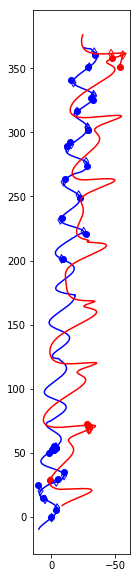

paremeters weighted by chi^2 with uncertainties from the fit
parallax 7.208159699916853 0.40448261902026217
pmra -1.298950982075734 0.13112729803971532
pmdec 27.308891749996143 0.5593561272110521
accra -0.17871782170728504 0.02240289094560252
accdec -0.05935690789319413 0.07315434277392334
ra0 246.64239092014495 3.0614014987444936e-07
dec0 -23.608769419660934 5.511343345082419e-07
eccentricity 0.7943438361225991 0.12440974721473533
period 1.7949763091195736 0.0
omega 0.38784267012354084 0.07677532766798313
semimajor axis 1 0.42230448108875934 4.0044778422118566e-13
semimajor axis 2 2.3841377190482245 4.813211583235903e-07
mass ratio 0.2153996894073285 0.06380920686772316
inclination 0.0 0.09621552450862428
Omega 0.2594242506987591 0.10056409051505087
time of passage [2457814.57575242] 20.636538523445765
paremeters from scatter
parallax 7.201809742725961 0.10660248160432248
pmra -1.2934985710830906 0.0915345607961235
pmdec 27.332990676397884 0.40457050042970366
accra -0.0004914732304219

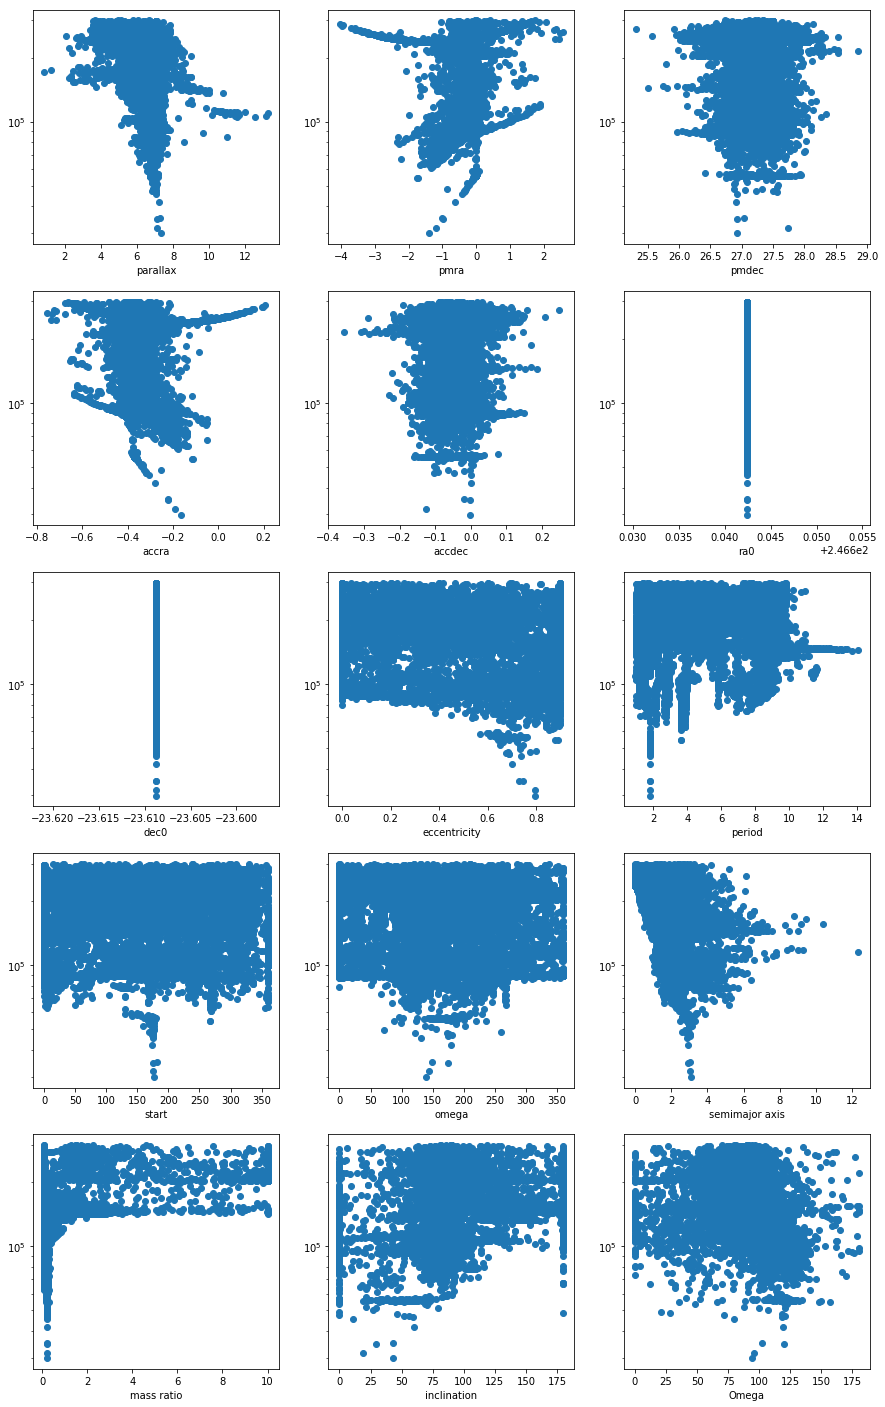

In [9]:
data=loaddata(0,1)
bestfit=rungrid(data,acceleration=True,startperiod=1,stopperiod=4,stepperiod=0.2,savepath='s1.pickle')
bestfit=pickle.load(open('s1.pickle',"rb"))
plotbest(data,bestfit)
outputsummaryfromfit(bestfit)
outputsummaryfromscatter(bestfit)
examine(bestfit)